In [102]:
import pandas as pd
import numpy as np
import pickle
import json

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [103]:
sims_file = '../01_GeneratePureSpectrums/sims_01.csv'
res_info_folder = '../01_GeneratePureSpectrums/ResInfo/res_info_'
sims_df = pd.read_csv(sims_file)
print(sims_df)
pickle_files = '../01_GeneratePureSpectrums/specs/'+sims_df['filename']+'.pkl'

   soil_resolution         function    id                      filename
0            7x7x7               Si  1000               7x7x7_Si_001000
1            7x7x7               Al  1001               7x7x7_Al_001001
2            7x7x7                H  1002                7x7x7_H_001002
3            7x7x7               Na  1003               7x7x7_Na_001003
4            7x7x7                O  1004                7x7x7_O_001004
5            7x7x7               Fe  1005               7x7x7_Fe_001005
6            7x7x7               Mg  1006               7x7x7_Mg_001006
7            7x7x7                C  1007                7x7x7_C_001007
8            7x7x7             SiO2  1008             7x7x7_SiO2_001008
9            7x7x7            Al2O3  1009            7x7x7_Al2O3_001009
10           7x7x7              H2O  1010              7x7x7_H2O_001010
11           7x7x7             Na2O  1011             7x7x7_Na2O_001011
12           7x7x7            Fe2O3  1012            7x7x7_Fe2O3

In [ ]:
i = 22

pickle_file = pickle_files[i]
soil_resolution = sims_df['soil_resolution'][i]
res_info_file = res_info_folder + str(soil_resolution) + '.json'
res_info = json.load(open(res_info_file, 'r'))
midpoints = np.array(res_info['midpoints'])
detector_tally_ids = [int(r) for r in res_info['detector_tally_ids']]
cell_ids = [int(r) for r in res_info['cell_ids']]
filename = sims_df['filename'][i]
sides = res_info['sides']
x_walls, y_walls, z_walls = sides
i_bins, i_spectrums= pickle.load(open(pickle_file, 'rb'))
energy_bins = i_bins[-1][-2]
detector_energy_bins = i_bins[0][-2]
detector_spec = i_spectrums[0]
causal_bins = [str(bin)[:len(str(cell_ids[0]))] for bin in i_bins[4][2]]
causal_bins = (np.array(causal_bins)).astype(int).tolist()
causal_energy_bins = i_bins[4][-2]
causal_spec = i_spectrums[4]
new_shape = np.array(causal_spec.shape)
new_shape[2] = len(cell_ids)
# print(new_shape)
new_array = np.zeros(new_shape)
for j in range(len(cell_ids)):
    if cell_ids[j] in causal_bins:
        new_array[:, :, j] = causal_spec[:, :, causal_bins.index(cell_ids[j])]
full_causal_spec = new_array

cell_heating = full_causal_spec[0, 0, :, 0, 0, 0, :, 0]
total_soil_heating = np.sum(cell_heating, axis=0)
heating_noise = causal_spec[0, 0, -1, 0, 0, 0, :, 0]
total_heating = total_soil_heating + heating_noise

(np.float64(1.2889669320000001e-13), np.float64(1.4178636252000002e-07))

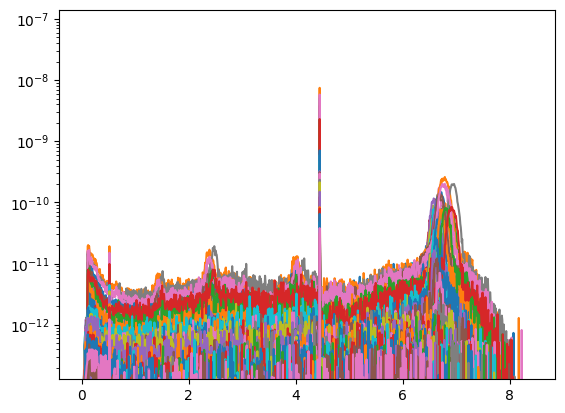

In [111]:
for n in range(len(cell_ids)):
    if cell_ids[n] in causal_bins:
        plt.plot(causal_energy_bins, full_causal_spec[0, 0, n, 0, 0, 0, :, 0], label=str(cell_ids[n]))



# plt.plot(causal_energy_bins, total_soil_heating, label='Total Soil Heating')
# plt.plot(causal_energy_bins, total_heating, label='+ Noise', linestyle='--', color='gray')
plt.yscale('log')

max_y = np.max(total_heating)
plt.ylim(max_y*1e-6, max_y * 1.1)


In [112]:

cells_over_total_heating = np.nan_to_num(np.divide(cell_heating, total_soil_heating), copy=False, nan=0.0, posinf=None, neginf=None)
cells_over_total_heating = cells_over_total_heating/np.sum(cells_over_total_heating)

/tmp/ipykernel_2129796/2033591874.py:1: RuntimeWarning: invalid value encountered in divide
  cells_over_total_heating = np.nan_to_num(np.divide(cell_heating, total_soil_heating), copy=False, nan=0.0, posinf=None, neginf=None)


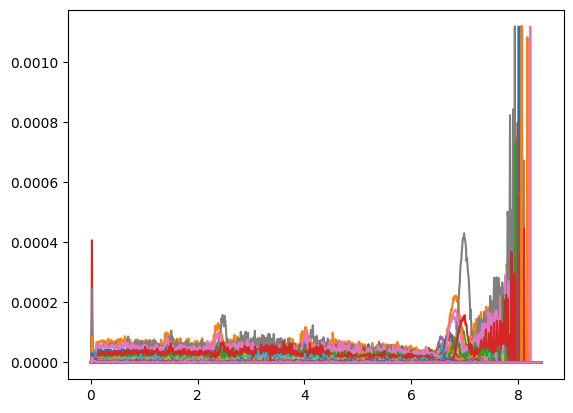

In [113]:
for n in range(len(cell_ids)):
    if cell_ids[n] in causal_bins:
        plt.plot(causal_energy_bins, cells_over_total_heating[n], label=str(cell_ids[n]))



# plt.plot(causal_energy_bins, total_soil_heating, label='Total Soil Heating')
# plt.plot(causal_energy_bins, total_heating, label='+ Noise', linestyle='--', color='gray')
# plt.yscale('log')

# max_y = np.max(total_heating)
# plt.ylim(max_y*1e-6, max_y * 1.1)
# plt.ylim(0, 1)

In [114]:
cell_portion = np.sum(cells_over_total_heating, axis=1)

In [115]:
cell_portion.shape

(343,)

In [116]:

sorted_indicies = np.argsort(cell_portion)[::-1]
sorted_vals = (cell_portion)[sorted_indicies]

In [117]:
def percent_cloud(sorted_indicies, sorted_vals, threshold=0.90):
    total = np.sum(sorted_vals)
    cumulative_sum = np.cumsum(sorted_vals)
    percent = cumulative_sum / total
    return sorted_indicies[percent < threshold]

In [118]:
len(percent_cloud(sorted_indicies, sorted_vals, threshold=0.99))

226

In [119]:
percent_cloud(sorted_indicies, sorted_vals, threshold=0.99).tolist(), percent_cloud(sorted_indicies, sorted_vals, threshold=0.90).tolist()
# set subtraction
len(set(percent_cloud(sorted_indicies, sorted_vals, threshold=0.99)) - set(percent_cloud(sorted_indicies, sorted_vals, threshold=0.90)))

130

In [120]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_box(ax, xmin, xmax, ymin, ymax, zmin, zmax, color, alpha=1, label=None, zorder=None):
    # Draw a rectangular box (RPP)
    x = [xmin, xmax]
    y = [ymin, ymax]
    z = [zmin, zmax]
    for s, e in [
        # bottom
        ([x[0], y[0], z[0]], [x[1], y[0], z[0]]),
        ([x[1], y[0], z[0]], [x[1], y[1], z[0]]),
        ([x[1], y[1], z[0]], [x[0], y[1], z[0]]),
        ([x[0], y[1], z[0]], [x[0], y[0], z[0]]),
        # top
        ([x[0], y[0], z[1]], [x[1], y[0], z[1]]),
        ([x[1], y[0], z[1]], [x[1], y[1], z[1]]),
        ([x[1], y[1], z[1]], [x[0], y[1], z[1]]),
        ([x[0], y[1], z[1]], [x[0], y[0], z[1]]),
        # sides
        ([x[0], y[0], z[0]], [x[0], y[0], z[1]]),
        ([x[1], y[0], z[0]], [x[1], y[0], z[1]]),
        ([x[1], y[1], z[0]], [x[1], y[1], z[1]]),
        ([x[0], y[1], z[0]], [x[0], y[1], z[1]])
    ]:
        ax.plot3D(*zip(s, e), color=color, alpha=alpha, zorder=zorder)
    if label:
        ax.text((xmin+xmax)/2, (ymin+ymax)/2, zmax, label, color=color, zorder=zorder)

def plot_cylinder(ax, base, vec, radius, height, color, alpha=1, label=None):
    # Draw a cylinder (RCC)
    x0, y0, z0 = base
    dx, dy, dz = vec
    # Normalize direction vector
    length = np.sqrt(dx**2 + dy**2 + dz**2)
    if length == 0:
        return
    dx, dy, dz = dx/length, dy/length, dz/length
    # Create cylinder along z, then rotate
    z = np.linspace(0, height, 30)
    theta = np.linspace(0, 2*np.pi, 30)
    theta_grid, z_grid = np.meshgrid(theta, z)
    x_grid = radius * np.cos(theta_grid)
    y_grid = radius * np.sin(theta_grid)
    # Build rotation matrix
    v = np.array([dx, dy, dz])
    v0 = np.array([0, 0, 1])
    if not np.allclose(v, v0):
        axis = np.cross(v0, v)
        angle = np.arccos(np.dot(v0, v))
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle)*K + (1-np.cos(angle))*(K@K)
        xyz = np.stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()])
        xyz_rot = R @ xyz
        x_grid = xyz_rot[0].reshape(x_grid.shape)
        y_grid = xyz_rot[1].reshape(y_grid.shape)
        z_grid = xyz_rot[2].reshape(z_grid.shape)
    x_grid += x0
    y_grid += y0
    z_grid += z0
    ax.plot_surface(x_grid, y_grid, z_grid, color=color, alpha=alpha, linewidth=0)
    if label:
        ax.text(x0, y0, z0+height/2, label, color=color)

In [121]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_cylinder(ax, base, vec, radius, height, color, alpha=1, label=None):
    # Draw a cylinder (RCC) with flat ends
    x0, y0, z0 = base
    dx, dy, dz = vec
    # Normalize direction vector
    length = np.sqrt(dx**2 + dy**2 + dz**2)
    if length == 0:
        return
    dx, dy, dz = dx/length, dy/length, dz/length
    # Create cylinder along z, then rotate
    z = np.linspace(0, height, 30)
    theta = np.linspace(0, 2*np.pi, 30)
    theta_grid, z_grid = np.meshgrid(theta, z)
    x_grid = radius * np.cos(theta_grid)
    y_grid = radius * np.sin(theta_grid)
    # Build rotation matrix
    v = np.array([dx, dy, dz])
    v0 = np.array([0, 0, 1])
    if not np.allclose(v, v0):
        axis = np.cross(v0, v)
        angle = np.arccos(np.clip(np.dot(v0, v), -1.0, 1.0))
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle)*K + (1-np.cos(angle))*(K@K)
        xyz = np.stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()])
        xyz_rot = R @ xyz
        x_grid = xyz_rot[0].reshape(x_grid.shape)
        y_grid = xyz_rot[1].reshape(y_grid.shape)
        z_grid = xyz_rot[2].reshape(z_grid.shape)
    x_grid += x0
    y_grid += y0
    z_grid += z0
    ax.plot_surface(x_grid, y_grid, z_grid, color=color, alpha=alpha, linewidth=0)

    # Flat ends
    for zc in [0, height]:
        # Circle in xy-plane
        x_end = radius * np.cos(theta)
        y_end = radius * np.sin(theta)
        z_end = np.full_like(x_end, zc)
        # Rotate
        xyz_end = np.stack([x_end, y_end, z_end])
        if not np.allclose(v, v0):
            xyz_end = R @ xyz_end
        x_end = xyz_end[0] + x0
        y_end = xyz_end[1] + y0
        z_end = xyz_end[2] + z0
        # Use Poly3DCollection for flat ends
        verts = [list(zip(x_end, y_end, z_end))]
        poly = Poly3DCollection(verts, color=color, alpha=alpha)
        ax.add_collection3d(poly)

    if label:
        ax.text(x0, y0, z0+height/2, label, color=color)

In [153]:
def plot_cone(ax, pos, vec, dir, length, color='red', alpha=1, label=None, zorder=None):
    """
    Draw a cone with end point at pos, pointing in direction vec, with angle from dir
    """
    x0, y0, z0 = pos
    dx, dy, dz = vec
    # Normalize direction vector
    norm = np.sqrt(dx**2 + dy**2 + dz**2)
    if norm == 0:
        return
    dx, dy, dz = dx/norm, dy/norm, dz/norm
    # Create cone base circle
    theta = np.linspace(0, 2*np.pi, 30)
    r = length * np.tan(np.radians(dir))
    x_circle = r * np.cos(theta)
    y_circle = r * np.sin(theta)
    z_circle = np.zeros_like(x_circle)
    # Rotate circle to point in direction vec
    v0 = np.array([0, 0, 1])
    v = np.array([dx, dy, dz])
    if not np.allclose(v, v0):
        axis = np.cross(v0, v)
        angle = np.arccos(np.clip(np.dot(v0, v), -1.0, 1.0))
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle)*K + (1-np.cos(angle))*(K@K)
        xyz = np.stack([x_circle.flatten(), y_circle.flatten(), z_circle.flatten()])
        xyz_rot = R @ xyz
        x_circle = xyz_rot[0].reshape(x_circle.shape)
        y_circle = xyz_rot[1].reshape(y_circle.shape)
        z_circle = xyz_rot[2].reshape(z_circle.shape)
    x_circle += x0 + dx * length
    y_circle += y0 + dy * length
    z_circle += z0 + dz * length
    # Draw cone surface
    for i in range(len(x_circle)):
        ax.plot([x0, x_circle[i]], [y0, y_circle[i]], [z0, z_circle[i]], color=color, alpha=alpha, zorder=zorder)
    if label:
        ax.text(x0, y0, z0 + dz * length / 2, label, color=color)
    

In [154]:
def frontfaceavg(midpoints, intensity, elev, azim):
    """
    Returns midpoints and intensity values averaged along the front face,
    and the index of the axis perpendicular to the front face.
    The axes are mapped to matplotlib's convention:
    vx = Y axis, vy = X axis, vz = Z axis
    """
    elev_rad = np.deg2rad(elev)
    azim_rad = np.deg2rad(azim)
    # Matplotlib convention: view vector
    vx = np.cos(elev_rad) * np.sin(azim_rad)  # Y axis
    vy = np.cos(elev_rad) * np.cos(azim_rad)  # X axis
    vz = np.sin(elev_rad)                     # Z axis
    # Map to [X, Y, Z] order
    view_vec = np.array([vy, vx, vz])
    idx = np.argmax(np.abs(view_vec))
    face_midpoints = np.delete(midpoints, idx, axis=1)
    unique_faces, indices = np.unique(face_midpoints, axis=0, return_inverse=True)
    avg_intensity = np.zeros(unique_faces.shape[0])
    for i in range(unique_faces.shape[0]):
        avg_intensity[i] = np.mean(intensity[indices == i])
    return unique_faces, avg_intensity, idx

In [155]:
def plot_detector_and_emitter(ax):
    plot_cylinder(ax, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='red', alpha=1, label='Detector')
    


In [156]:
def plot_MCNP(ax):
    # Detector (surface 21)
    plot_cylinder(ax, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='red', alpha=1, label='Detector')

    # Shielding boxes (RPPs)
    plot_box(ax, 19, 29, -7.5, 7.5, -11, 9, color='blue', alpha=1, label='PbPE')
    plot_box(ax, 9, 19, 4, 9, -11, 9, color='cyan', alpha=1)
    plot_box(ax, 9, 19, -9, -4, -11, 9, color='cyan', alpha=1)
    plot_box(ax, 19, 29, 7.5, 12.5, -11, 9, color='cyan', alpha=1)
    plot_box(ax, 19, 29, -12.5, -7.5, -11, 9, color='cyan', alpha=1)
    plot_box(ax, 29, 34, -15, 15, -11, 9, color='cyan', alpha=1)
    plot_box(ax, 9, 19, -4, 4, 4, 9, color='cyan', alpha=1)
    plot_box(ax, -26, 26, 18, 28, -11, 9, color='green', alpha=1, label='BA1')
    plot_box(ax, -26, 26, -28, -18, -11, 9, color='green', alpha=1, label='BA2')
    plot_box(ax, -65, 65, -28, 28, 10, 10.5, color='magenta', alpha=1, label='Al')

    # Wheels (outer treads only for clarity)
    plot_cylinder(ax, base=(-2, 77, 8), vec=(0, 25, 0), radius=29, height=25, color='orange', alpha=0.2, label='Wheel 1')
    plot_cylinder(ax, base=(68, 77, 8), vec=(0, 25, 0), radius=29, height=25, color='orange', alpha=0.2, label='Wheel 2')
    plot_cylinder(ax, base=(-2, -77, 8), vec=(0, -25, 0), radius=29, height=25, color='orange', alpha=0.2, label='Wheel 3')
    plot_cylinder(ax, base=(68, -77, 8), vec=(0, -25, 0), radius=29, height=25, color='orange', alpha=0.2, label='Wheel 4')

    # Soil volume (bounding box)
    plot_box(ax, -56, 56, -45, 45, 42, 92, color='brown', alpha=1, label='Soil')


In [157]:
def ax_resize(ax, size=0.7, leftward=False):
    _x0 = ax.get_position().x0
    _y0 = ax.get_position().y0
    _x1 = ax.get_position().x1
    _y1 = ax.get_position().y1
    # _size = .7
    # # shrink while keeping the position centered
    _center_x = (_x0 + _x1) / 2
    _len_x = (_x1 - _x0) * size
    _center_y = (_y0 + _y1) / 2
    _len_y = (_y1 - _y0) * size
    if leftward:
        ax.set_position([_x0, _center_y - _len_y/2, _len_x, _len_y])
    else:
        ax.set_position([_center_x - _len_x/2, _center_y - _len_y/2, _len_x, _len_y])

In [158]:
def ax_translate(ax, x=0, y=0):
    _x0 = ax.get_position().x0 + x
    _y0 = ax.get_position().y0 + y
    _x1 = ax.get_position().x1 + x
    _y1 = ax.get_position().y1 + y
    ax.set_position([_x0, _y0, _x1 - _x0, _y1 - _y0])

In [159]:
def VIS1(midpoints, intensity, spectrums, noise=None, elev=20, azim=-60, n=0, figsize=(12,10), filetail='', filehead='', filetype=''):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(221, projection='3d')
        ax2 = fig.add_subplot(222, projection='3d')

        ax.set_proj_type('ortho')
        ax2.set_proj_type('ortho')


        ax.scatter(midpoints[:, 0], midpoints[:, 1], -midpoints[:, 2]+42, 
                   c=intensity,
                #    c='red', 
                   marker='o', 
                #    s=20,
                s=(intensity/np.max(intensity))*800, 
                # alpha=1,
                alpha=1,
                # # now give an outline to the points
                edgecolor='black', linewidth=0.25
                )
        sc = ax2.scatter(midpoints[:, 0], midpoints[:, 1], midpoints[:, 2], 
                         c=intensity,
                        #  c='red', 
                         marker='o', 
                        s=(intensity/np.max(intensity))*800, 
                        #  s=80, 
                        # alpha=1,
                        alpha=1,
                        edgecolor='black', linewidth=0.5
                        )
        ax2.scatter(midpoints[:, 0], midpoints[:, 1], midpoints[:, 2], 
                        #  c=intensity,
                         c='grey', 
                         marker='o', 
                        s=800, 
                        #  s=80, 
                        # alpha=1,
                        alpha=.1,
                        edgecolor='black', linewidth=0.5
                        )

        plot_MCNP(ax)

        # print(frontface(elev, azim))

        ax.set_xlabel('X (cm)')
        ax.set_ylabel('Y (cm)')
        ax.set_zlabel('Z (cm)')
        ax.set_title('MCNP Geometry Visualization')
        ax.view_init(elev=elev, azim=azim)
        ax.invert_zaxis()


        ax2.set_xlabel('X (cm)')
        ax2.set_ylabel('Y (cm)')
        ax2.set_zlabel('Z (cm)')
        ax2.set_title('Soil Visualization')
        ax2.view_init(elev=elev, azim=azim)


        ax3 = fig.add_subplot(224)


        unique_faces, avg_intensity, idx = frontfaceavg(midpoints, intensity=intensity, elev=elev, azim=azim)
        pos_axis = ['X', 'Y', 'Z']
        pos_labels = ['Front', 'Left', 'Top']
        pos_axis.remove(pos_axis[idx])
        ax3.set_xlabel(pos_axis[0] + ' (cm)')
        ax3.set_ylabel(pos_axis[1] + ' (cm)')
        ax3.set_title(f'{pos_labels[idx]} Face Average Intensity')

        # make sure the colors are the same as in the 3d plot
        avg_intensity_c = avg_intensity


        ax4 = fig.add_subplot(223)
        ax4.set_xlabel('Energy (MeV)')
        ax4.set_ylabel('Probability')
        ax4.set_title('Sum of all Spectra')
        ax4.plot(detector_energy_bins, spectrums[n], label='Cell ID: {}'.format(cell_ids[n]), c='red')
        ax4.plot(detector_energy_bins, spectrums.sum(axis=0).flatten(), label='Total Spectra')
        if noise is not None:
            ax4.plot(detector_energy_bins, noise, label='+ Noise', c='black', linestyle='--')
        ax4.set_yscale('log')
        ax4.legend(loc='upper right')

        ax.scatter(midpoints[n, 0], midpoints[n, 1], -midpoints[n, 2]+42, marker='o', c='red', s=1000, label='Cell ID: {}'.format(cell_ids[n]), alpha=.5, edgecolor='red', linewidth=1)
        ax2.scatter(midpoints[n, 0], midpoints[n, 1], midpoints[n, 2], marker='o', c='red', s=1000, label='Cell ID: {}'.format(cell_ids[n]), alpha=.5, edgecolor='red', linewidth=1)

        midpoint = midpoints[n, 0]
        midpoint = np.delete(midpoints[n, :], idx)

        ax3.scatter(x=midpoint[0], y=midpoint[1], marker='o', c='red', s=1000, label='Cell ID: {}'.format(cell_ids[n]), alpha=.5, edgecolor='red', linewidth=1)
        ax3.scatter(x=unique_faces[:, 0], y=unique_faces[:, 1], c=avg_intensity_c, marker='o',s=700)

        fig.colorbar(sc, ax=ax3, label='Intensity', shrink=1, aspect=10)
        plt.suptitle(f'{filename} Geometry and Effective Map', fontsize=16)
        # plt.show()
        # make transparent background
        # fig.patch.set_alpha(0.0)
        if filetype:
            plt.savefig(f'{filehead}{filename}{filetail}.{filetype}', dpi=300, bbox_inches='tight')
            plt.close(fig)

        else:
                plt.show()
                plt.close(fig)


In [160]:
default_dpi = 300
image_resolution = (300*12, 300*10)  # Full HD resolution
image_resolution

(3600, 3000)

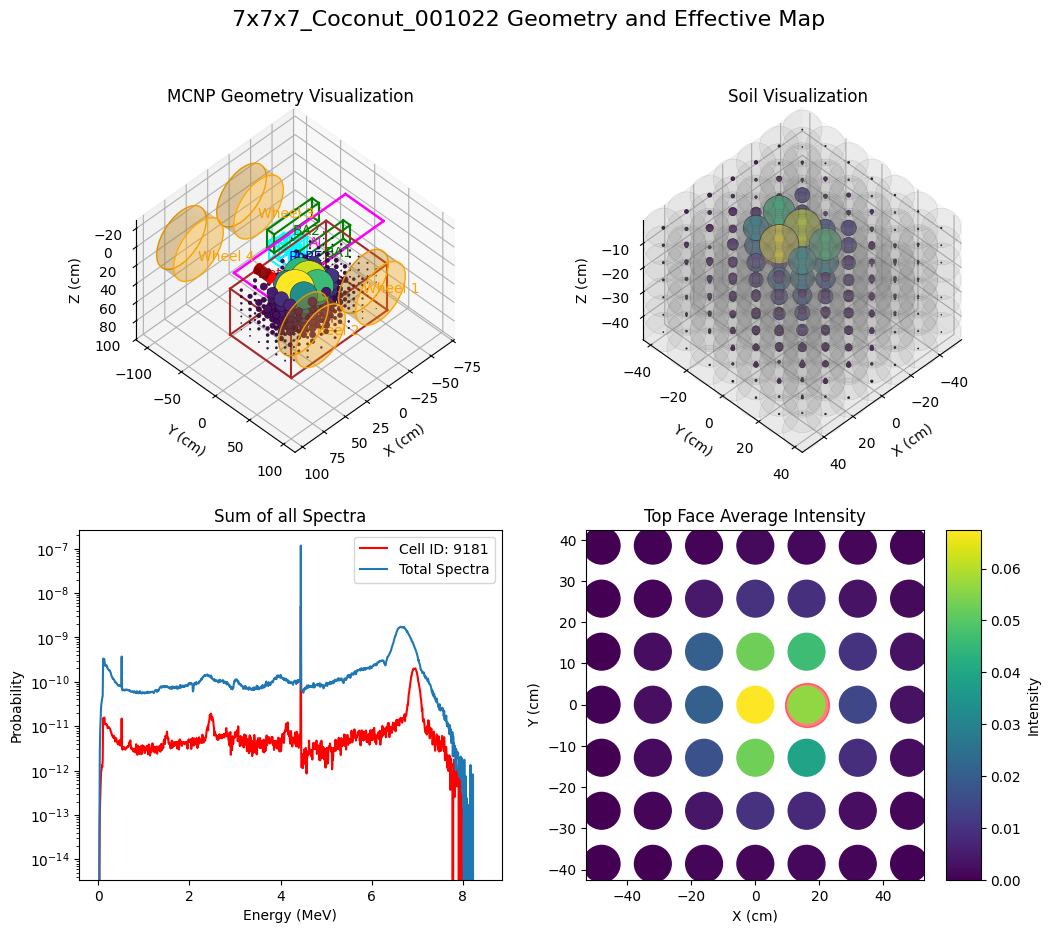

In [161]:
VIS1(
    midpoints,
    intensity=cell_portion,
    spectrums=cell_heating,
    elev=45,
    azim=45,
    # elev=20,
    # azim=45,
    n=np.argsort(cell_portion)[::-1][0],
    )

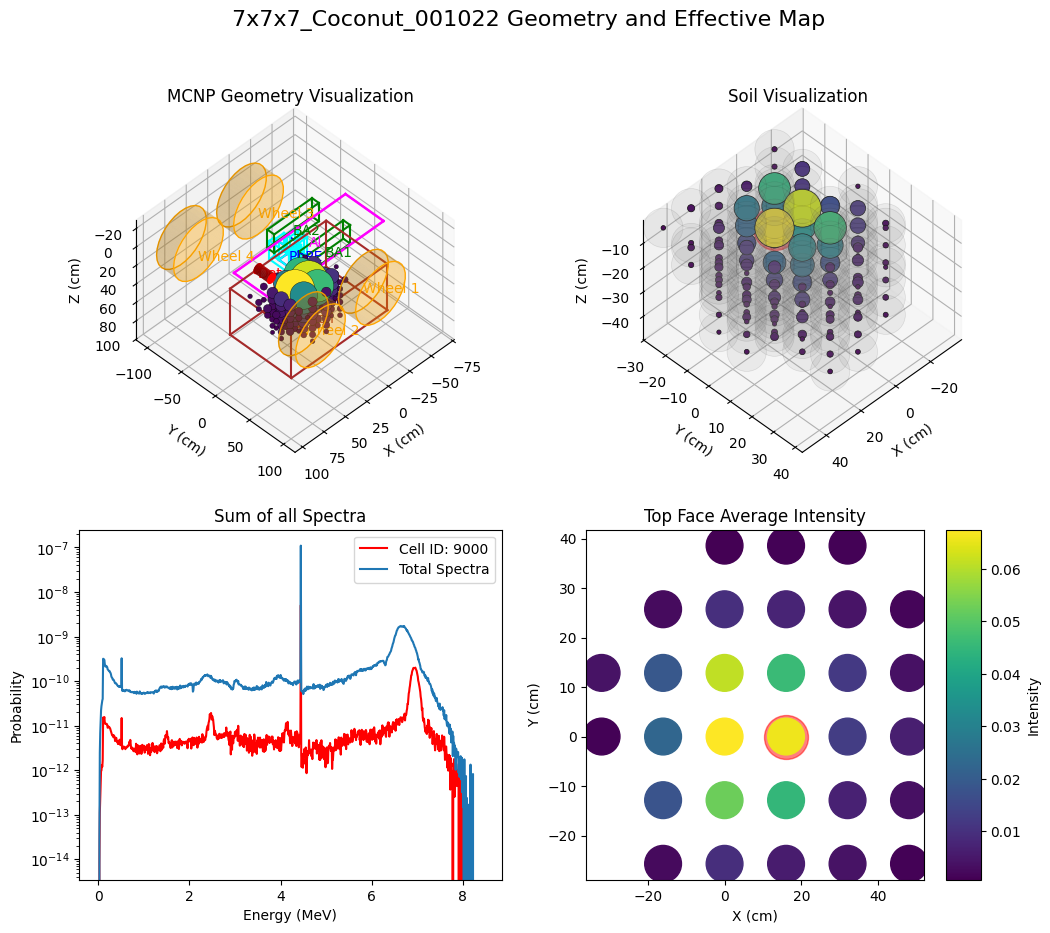

In [162]:
cloud = percent_cloud(sorted_indicies, sorted_vals, threshold=0.95)
VIS1(
    midpoints[cloud],
    intensity=cell_portion[cloud],
    spectrums=cell_heating[cloud],
    elev=45,
    azim=45,
    # elev=20,
    # azim=-90,
    n=np.argsort(cell_portion[cloud])[::-1][0],
    )

In [163]:
x_walls

[-56.0, -40.0, -24.0, -8.0, 8.0, 24.0, 40.0, 56.0]

In [164]:
# use the midpoints to make a voxel grid

def make_voxel_grid(midpoints, intensity):
    """
    Create a voxel grid from midpoints and intensity values.
    """
    # Create a grid of zeros
    grid_shape = (len(np.unique(midpoints[:, 0])),
                  len(np.unique(midpoints[:, 1])),
                  len(np.unique(midpoints[:, 2])))
    voxel_grid = intensity.reshape(grid_shape)
    return voxel_grid

voxel_grid = make_voxel_grid(midpoints, intensity=cell_portion)


In [165]:
# function to reverse the voxel grid to intensity values shape

def reverse_voxel_grid(voxel_grid, midpoints):
    """
    Reverse the voxel grid to match the shape of midpoints.
    """
    # Create an array of zeros with the same shape as midpoints
    intensity = np.zeros(midpoints.shape[0])
    
    # Get unique coordinates
    unique_x = np.unique(midpoints[:, 0])
    unique_y = np.unique(midpoints[:, 1])
    unique_z = np.unique(midpoints[:, 2])
    
    # Create a mapping from coordinates to indices in the voxel grid
    x_map = {x: i for i, x in enumerate(unique_x)}
    y_map = {y: i for i, y in enumerate(unique_y)}
    z_map = {z: i for i, z in enumerate(unique_z)}
    
    # Fill the intensity array using the voxel grid
    for i, (x, y, z) in enumerate(midpoints):
        xi = x_map[x]
        yi = y_map[y]
        zi = z_map[z]
        intensity[i] = voxel_grid[xi, yi, zi]
    
    return intensity

In [166]:
cell_mask = np.zeros(cell_portion.shape, dtype=bool)
cell_mask[cloud] = True


cell_mask_vox = make_voxel_grid(midpoints, intensity=cell_mask)

# cell_mask_vox[:, :3] = False
# cell_mask_vox[:, 5:] = False

In [167]:
cell_mask_vox[:3].shape

(3, 7, 7)

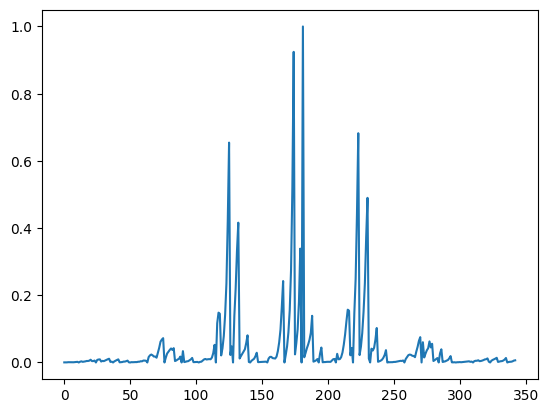

In [168]:
plt.plot((voxel_grid/np.max(voxel_grid)).flatten())

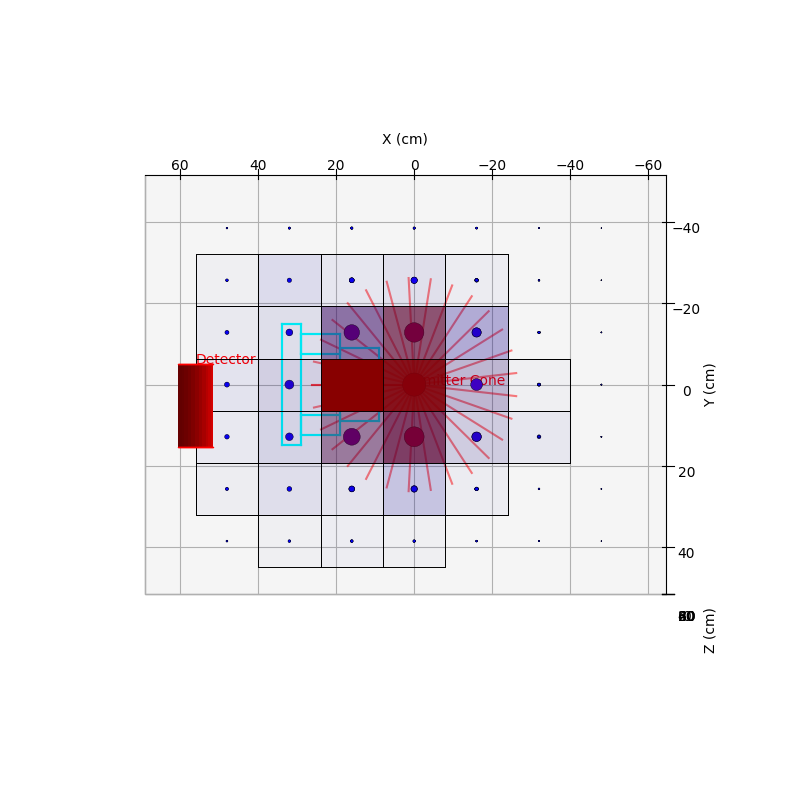

In [169]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Convert wall lists to numpy arrays
x = np.array(x_walls)
y = np.array(y_walls)
z = np.array(z_walls)

# Create meshgrid for voxel corners
X, Y, Z = np.meshgrid(x, y, -z+42, indexing='xy')

# Create a mask for nonzero voxels
mask = cell_mask_vox

# Normalize voxel_grid for coloring
norm = plt.Normalize(voxel_grid[mask].min(), voxel_grid[mask].max())
colors = plt.cm.cool(norm(voxel_grid))

colors[..., -1] = voxel_grid/np.max(voxel_grid)  # Set alpha based on intensity
colors[..., 0] = voxel_grid/np.max(voxel_grid)  # Set alpha based on intensity
colors[..., 2] = 1-(voxel_grid/np.max(voxel_grid))  # Set alpha based on intensity
colors[..., 1] = 0

# Plot the voxels


c = plt.cm.cool(norm(cell_portion))
c[..., -1] = cell_portion/np.max(cell_portion)  # Set alpha based on intensity
c[..., 0] = cell_portion/np.max(cell_portion)  # Set alpha based on intensity
c[..., 2] = 1-(cell_portion/np.max(cell_portion))  # Set alpha based on intensity
c[..., 1] = 0

ax.scatter(midpoints[:, 0], midpoints[:, 1], -midpoints[:, 2]+42, 
        c=c,
    #    c='red', 
        marker='o', 
    #    s=20,
    s=(cell_portion/np.max(cell_portion))*300, 
    # alpha=1,
    alpha=1,
    # # now give an outline to the points
    edgecolor='black', linewidth=0.30
    )

ax.voxels(
    X, 
    Y, 
    Z, 
    mask, 
    facecolors=colors,
    # facecolors='white',
    edgecolor='k',linewidth=0.5,
    # alpha=.1,
)
# plot_MCNP(ax)

ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
# flip z-axis
ax.invert_zaxis()
ax.set_proj_type('ortho')
ax.view_init(elev=90, azim=90)

plot_cone(ax, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='red', alpha=.5, label='Emitter Cone')

ax.set_aspect('equal')
plot_cylinder(ax, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='red', alpha=1, label='Detector')


plot_box(ax, 9, 19, 4, 9, -11, 9, color='cyan', alpha=1)
plot_box(ax, 9, 19, -9, -4, -11, 9, color='cyan', alpha=1)
plot_box(ax, 19, 29, 7.5, 12.5, -11, 9, color='cyan', alpha=1)
plot_box(ax, 19, 29, -12.5, -7.5, -11, 9, color='cyan', alpha=1)
plot_box(ax, 29, 34, -15, 15, -11, 9, color='cyan', alpha=1)
plot_box(ax, 9, 19, -4, 4, 4, 9, color='cyan', alpha=1)
plt.show()

In [170]:
mask.shape

(7, 7, 7)

In [171]:
# write a function that gets the outer walls of the voxel grid, do this by checking each voxel and checking if it is surrounded by other voxels, if it is not, then it is an outer wall, have the function return the indices of the outer walls
def get_outer_walls(voxel_grid):
    outer_walls = []
    for i in range(voxel_grid.shape[0]):
        for j in range(voxel_grid.shape[1]):
            for k in range(voxel_grid.shape[2]):
                if voxel_grid[i, j, k] == True:
                    # Check if the voxel is surrounded by other voxels
                    if (i == 0 or voxel_grid[i-1, j, k] == 0) or \
                       (i == voxel_grid.shape[0]-1 or voxel_grid[i+1, j, k] == 0) or \
                       (j == 0 or voxel_grid[i, j-1, k] == 0) or \
                       (j == voxel_grid.shape[1]-1 or voxel_grid[i, j+1, k] == 0):
                        outer_walls.append((i, j, k))
    return outer_walls
outer_walls = get_outer_walls(cell_mask_vox)

In [172]:
cell_mask_vox.sum(axis=2)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 6, 6, 7, 2, 1],
       [0, 0, 6, 7, 6, 7, 2],
       [0, 5, 6, 7, 6, 7, 2],
       [0, 1, 7, 6, 7, 5, 3],
       [0, 0, 6, 6, 7, 3, 2],
       [0, 0, 0, 1, 1, 1, 0]])

In [173]:
cell_mask_vox[outer_walls].sum(axis=2)

array([[[2, 3, 3, ..., 4, 3, 4],
        [4, 4, 3, ..., 4, 5, 5],
        [2, 3, 3, ..., 4, 3, 4]],

       [[2, 3, 3, ..., 4, 3, 4],
        [4, 4, 3, ..., 4, 5, 5],
        [4, 4, 3, ..., 4, 5, 5]],

       [[2, 3, 3, ..., 4, 3, 4],
        [4, 4, 3, ..., 4, 5, 5],
        [4, 5, 5, ..., 5, 5, 4]],

       ...,

       [[0, 0, 0, ..., 0, 0, 3],
        [4, 5, 5, ..., 5, 5, 4],
        [0, 0, 0, ..., 0, 0, 3]],

       [[0, 0, 0, ..., 0, 0, 3],
        [3, 3, 3, ..., 6, 5, 5],
        [0, 0, 0, ..., 0, 0, 3]],

       [[0, 0, 0, ..., 0, 0, 3],
        [2, 3, 3, ..., 3, 4, 5],
        [0, 0, 0, ..., 0, 0, 3]]])

In [174]:
cell_mask_vox

array([[[False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False]],

       [[False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [False,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False,  True, False,  True],
        [False, False, False, False, False, False,  True]],

       [[False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [ True,  True,  True, False,  True,  True,  

In [175]:
cell_mask_walls_vox = np.zeros_like(cell_mask_vox, dtype=bool)
# cell_mask_walls_vox[:, :, :] = False
for i, j, k in outer_walls:
    cell_mask_walls_vox[i, j, k] = True

In [176]:
len(outer_walls)

101

In [177]:
cell_mask_walls_vox.sum(axis=2)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 6, 6, 7, 2, 1],
       [0, 0, 6, 3, 1, 6, 2],
       [0, 5, 2, 3, 1, 6, 2],
       [0, 1, 6, 1, 4, 3, 3],
       [0, 0, 6, 5, 6, 2, 2],
       [0, 0, 0, 1, 1, 1, 0]])

In [178]:
mask = cell_mask_walls_vox
flat_mask = reverse_voxel_grid(cell_mask_walls_vox, midpoints)


In [179]:
sum(mask == make_voxel_grid(midpoints, intensity=mask.flatten()))

array([[7, 7, 7, 7, 7, 7, 7],
       [7, 7, 7, 7, 7, 7, 7],
       [7, 7, 7, 7, 7, 7, 7],
       [7, 7, 7, 7, 7, 7, 7],
       [7, 7, 7, 7, 7, 7, 7],
       [7, 7, 7, 7, 7, 7, 7],
       [7, 7, 7, 7, 7, 7, 7]])

In [180]:
mask = cell_mask_walls_vox
flat_mask = mask.flatten()

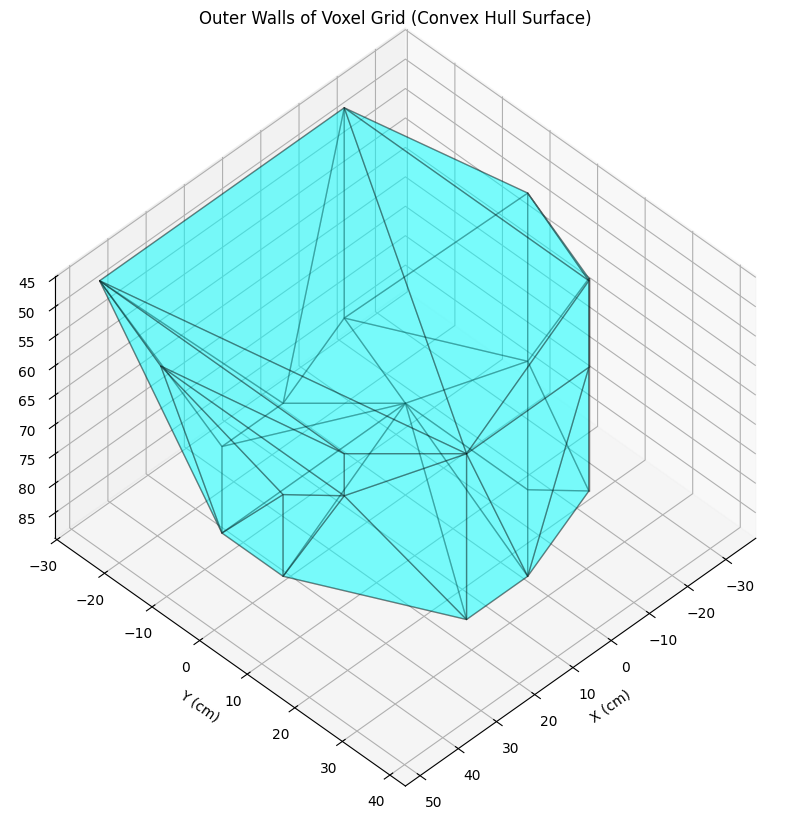

In [181]:
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

points = midpoints[flat_mask].copy()
points[:, 2] = -points[:, 2] + 42  # adjust z as in your scatter

if len(points) >= 4:
    hull = ConvexHull(points)
    # Plot the triangles of the convex hull
    faces = [points[simplex] for simplex in hull.simplices]
    poly3d = Poly3DCollection(faces, alpha=0.3, facecolor='cyan', edgecolor='k')
    ax.add_collection3d(poly3d)

ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.set_title('Outer Walls of Voxel Grid (Convex Hull Surface)')
ax.set_proj_type('ortho')
ax.invert_zaxis()
ax.view_init(elev=45, azim=45)
plt.show()


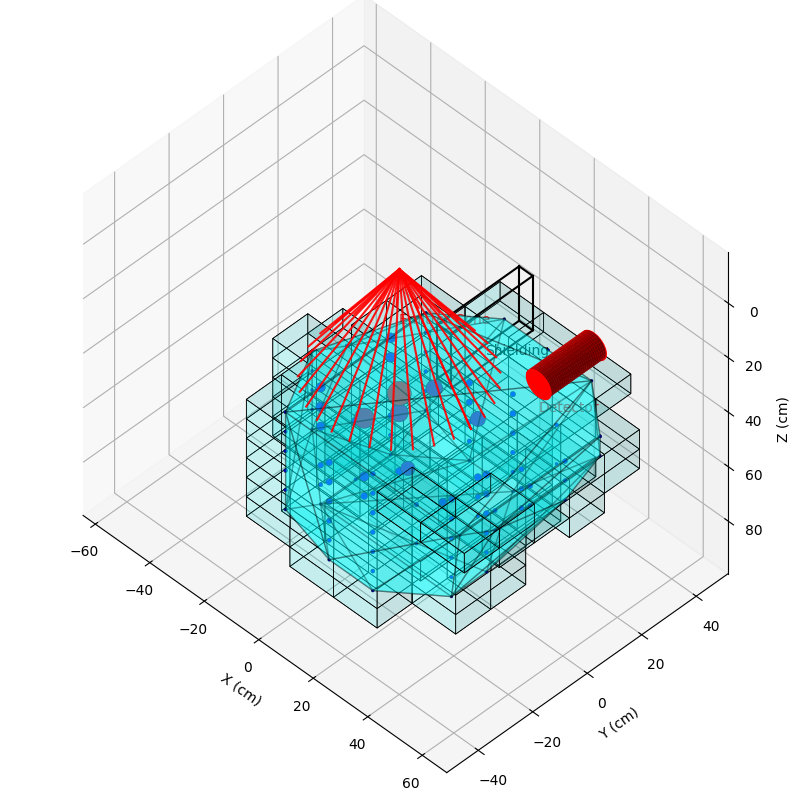

In [198]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Convert wall lists to numpy arrays
x = np.array(x_walls)
y = np.array(y_walls)
z = np.array(z_walls)

# Create meshgrid for voxel corners
X, Y, Z = np.meshgrid(x, y, -z+42, indexing='xy')

# Normalize voxel_grid for coloring
norm = plt.Normalize(voxel_grid[mask].min(), voxel_grid[mask].max())
colors = plt.cm.cool(norm(voxel_grid))

colors[..., -1] = voxel_grid/np.max(voxel_grid)  # Set alpha based on intensity
colors[..., 0] = voxel_grid/np.max(voxel_grid)  # Set alpha based on intensity
colors[..., 2] = 1-(voxel_grid/np.max(voxel_grid))  # Set alpha based on intensity
colors[..., 1] = 0

# Plot the voxels


c = plt.cm.cool(norm(cell_portion))
c[..., -1] = cell_portion/np.max(cell_portion)  # Set alpha based on intensity
c[..., 0] = cell_portion/np.max(cell_portion)  # Set alpha based on intensity
c[..., 2] = 1-(cell_portion/np.max(cell_portion))  # Set alpha based on intensity
c[..., 1] = 0

ax.scatter(
    midpoints[flat_mask][:, 0], 
    midpoints[flat_mask][:, 1], 
    -midpoints[flat_mask][:, 2]+42, 
        c=c[flat_mask],
    #    c='red', 
        marker='o', 
    #    s=20,
    # s=300, 
    s=(cell_portion[flat_mask]/np.max(cell_portion[flat_mask]))*300,
    alpha=1,
    # alpha=flat_mask,
    # # now give an outline to the points
    edgecolor='black', linewidth=0.30,
    zorder=1
    )


ax.voxels(
    X, 
    Y, 
    Z, 
    mask, 
    # facecolors=colors,
    facecolors='cyan',
    edgecolor='k',linewidth=0.5,
    alpha=.1,
    zorder=2
    )
# plot_MCNP(ax)

ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
# flip z-axis
ax.invert_zaxis()
ax.set_proj_type('ortho')

plot_cone(ax, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='red', alpha=.9, label='Emitter Cone', zorder=2000)

plot_cylinder(ax, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='red', alpha=1, label='Detector')




points = midpoints[flat_mask].copy()
points[:, 2] = -points[:, 2] + 42  # adjust z as in your scatter

if len(points) >= 4:
    hull = ConvexHull(points)
    # Plot the triangles of the convex hull
    faces = [points[simplex] for simplex in hull.simplices]
    poly3d = Poly3DCollection(faces, alpha=0.3, facecolor='cyan', edgecolor='k', zorder=10)
    ax.add_collection3d(poly3d)

# plot_box(ax, 9, 19, 4, 9, -11, 9, color='black', alpha=1, zorder=101)
# plot_box(ax, 9, 19, -9, -4, -11, 9, color='black', alpha=1, zorder=101)
# plot_box(ax, 19, 29, 7.5, 12.5, -11, 9, color='black', alpha=1, zorder=101)
# plot_box(ax, 19, 29, -12.5, -7.5, -11, 9, color='black', alpha=1, zorder=101)
plot_box(ax, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=101, label='Shielding')
# plot_box(ax, 9, 19, -4, 4, 4, 9, color='black', alpha=1, zorder=101)

ax.set_aspect('equal')

ax.view_init(elev=45, azim=-90+45)

plt.show()